In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import uniform, invgamma, bernoulli, poisson, norm
import statsmodels.api as sm
import pandas as pd
from src.preprocessing import prepare_data, prepare_data_no_standardizing, MAR_data_deletion
from src.model_code import Gibbs_MH
from src.diagnostics import MCMC_diagnostics
import pymc3 as pm
import arviz as az
from statsmodels.tsa.stattools import acf 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# MAR model on MAR data and saving results

In [ ]:
df = pd.read_csv('student-mat.csv', sep=",")
features = ["age", "sex", "failures", "higher", "Medu", 
            "absences", "G2", "G3"]
df = df[features]
df.head()

In [ ]:
X_df, y_df = prepare_data_no_standardizing(df)
X_df.head()

In [ ]:
X_df_missing = MAR_data_deletion(X_df, 0.05, 0.05, 'higher_yes', 'G2')

In [ ]:
X = X_df_missing
y = y_df.to_numpy()
B = 2000
thin = 10

In [ ]:
(betas, sigmas2, higher_yes_sim, G2_sim, alphas, gammas, etas) = Gibbs_MH(X, y, B, thin)

In [ ]:
betas_df = pd.DataFrame(betas.T, columns=[f"beta_{i}" for i in X_df.columns])
higher_yes_df = pd.DataFrame(higher_yes_sim.T, columns=[f"missing_higher_yes_{i}" for i in range(0, higher_yes_sim.shape[0])])
G2_df = pd.DataFrame(G2_sim.T, columns=[f"missing_G2_{i}" for i in range(0, G2_sim.shape[0])])
alphas_df = pd.DataFrame(alphas.T, columns=[f"alpha_{i}" for i in range(0, alphas.shape[0])])
gammas_df = pd.DataFrame(gammas.T, columns=[f"gamma_{i}" for i in range(0, gammas.shape[0])])
rest_df = pd.DataFrame({"sigmas2": sigmas2.T,
                        "eta2": etas.T})

In [ ]:
betas_df.shape

In [ ]:
results = pd.concat([betas_df , higher_yes_df, G2_df, alphas_df, gammas_df, rest_df], axis=1) 
results.head()
results.to_csv("results/03_results_not_thinned_(G2).csv")

In [ ]:
for i, alpha in enumerate(alphas):
    MCMC_diagnostics(alpha, f"alpha_{i}")

In [ ]:
for i, gamma in enumerate(gammas):
    MCMC_diagnostics(gamma, f"gamma_{i}")

In [ ]:
MCMC_diagnostics(sigmas2, "sigma2")

In [ ]:
MCMC_diagnostics(etas, "eta2")

In [ ]:
for i, beta in enumerate(betas):
    MCMC_diagnostics(beta, X_df.columns[i])

In [ ]:
plt.subplot(121)
plt.hist(higher_yes_sim.flatten())
plt.title(f'Simulated higher_yes')


plt.subplot(122)
plt.hist(X.loc[:, "higher_yes"])
plt.title(f'Observed higher_yes')

plt.show()

In [ ]:
plt.subplot(121)
plt.hist(G2_sim.flatten(), bins=30)
plt.title(f'Simulated missing G2')

plt.subplot(122)
plt.hist(X.loc[:, "G2"], bins=30)
plt.title(f'Observed G2')
plt.show()



# Generate multiple betas

In [ ]:
y = y_df.to_numpy()
B = 2000
thin = 10
for prop in [0.05, 0.1, 0.25, 0.5]:
    X = MAR_data_deletion(X_df, prop, prop, 'higher_yes', 'G2')
    (betas, sigmas2, higher_yes_sim, G2_sim, alphas, gammas, etas) = Gibbs_MH(X, y, B, thin)
    results = pd.DataFrame(betas.T, columns = X_df.columns)
    results.to_csv(f'results/03_dists_{prop}.csv', index=False)

# Simulated vs. Observed
## 0.2 missing

In [3]:
df = pd.read_csv('student-mat.csv', sep=",")
features = ["age", "sex", "failures", "higher", "Medu", 
            "absences", "G2", "G3"]
df = df[features]
X_df, y_df = prepare_data_no_standardizing(df)
X = MAR_data_deletion(X_df, 0.25, 0.25, 'higher_yes', 'G2')
y = y_df.to_numpy()
B = 2000
thin = 10
(betas, sigmas2, higher_yes_sim, G2_sim, alphas, gammas, etas) = Gibbs_MH(X, y, B, thin)

100%|██████████| 39999/39999 [05:52<00:00, 113.45it/s]


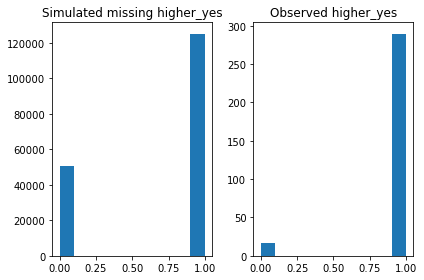

In [4]:
plt.subplot(121)
plt.hist(higher_yes_sim.flatten())
plt.title(f'Simulated missing higher_yes')


plt.subplot(122)
plt.hist(X.loc[:, "higher_yes"])
plt.title(f'Observed higher_yes')

plt.tight_layout()
# plt.savefig('figures/MAR_0.1_higher_yes.png')
plt.show()

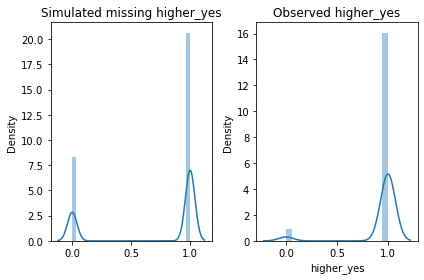

In [6]:
import seaborn as sns
plt.subplot(121)
sns.distplot(higher_yes_sim.flatten())
plt.title(f'Simulated missing higher_yes')


plt.subplot(122)
sns.distplot(X.loc[:, "higher_yes"])
plt.title(f'Observed higher_yes')
plt.savefig('figures/MAR_0.1_higher_yes.png')

plt.tight_layout()

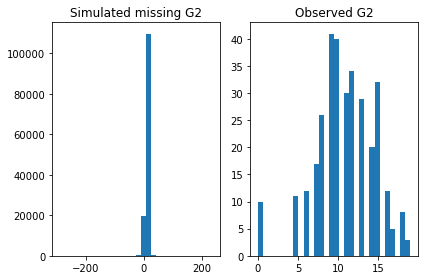

In [7]:
plt.subplot(121)
plt.hist(G2_sim.flatten(), bins=30)
plt.title(f'Simulated missing G2')

plt.subplot(122)
plt.hist(X.loc[:, "G2"], bins=30)
plt.title(f'Observed G2')

plt.tight_layout()
#plt.savefig('figures/MAR_0.1_G2.png')
plt.show()

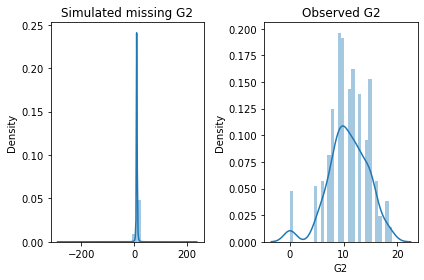

In [8]:
plt.subplot(121)
sns.distplot(G2_sim.flatten(), bins=30)
plt.title(f'Simulated missing G2')

plt.subplot(122)
sns.distplot(X.loc[:, "G2"], bins=30)
plt.title(f'Observed G2')

plt.tight_layout()
plt.savefig('figures/MAR_0.1_G2.png')
plt.show()

In [ ]:
# sns.boxplot(x=pd.Series(G2_sim.flatten()))

# 0.05 missing

In [9]:
df = pd.read_csv('student-mat.csv', sep=",")
features = ["age", "sex", "failures", "higher", "Medu", 
            "absences", "G2", "G3"]
df = df[features]
X_df, y_df = prepare_data_no_standardizing(df)
X = MAR_data_deletion(X_df, 0.05, 0.05, 'higher_yes', 'G2')
y = y_df.to_numpy()
B = 2000
thin = 10
(betas, sigmas2, higher_yes_sim, G2_sim, alphas, gammas, etas) = Gibbs_MH(X, y, B, thin)

100%|██████████| 39999/39999 [05:25<00:00, 122.96it/s]


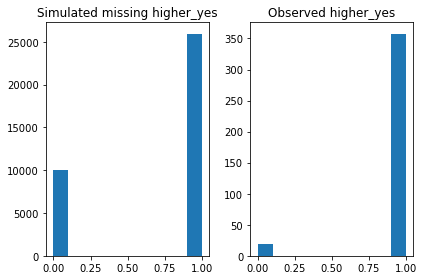

In [10]:
plt.subplot(121)
plt.hist(higher_yes_sim.flatten())
plt.title(f'Simulated missing higher_yes')


plt.subplot(122)
plt.hist(X.loc[:, "higher_yes"])
plt.title(f'Observed higher_yes')

plt.tight_layout()
# plt.savefig('figures/MAR_0.1_higher_yes.png')
plt.show()

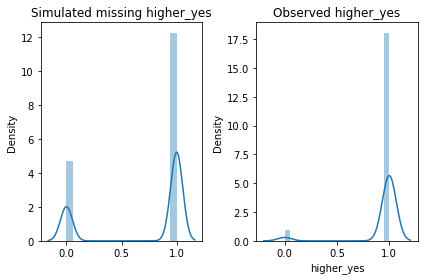

In [11]:
plt.subplot(121)
sns.distplot(higher_yes_sim.flatten())
plt.title(f'Simulated missing higher_yes')


plt.subplot(122)
sns.distplot(X.loc[:, "higher_yes"])
plt.title(f'Observed higher_yes')
plt.savefig('figures/MAR_0.05_higher_yes.png')

plt.tight_layout()

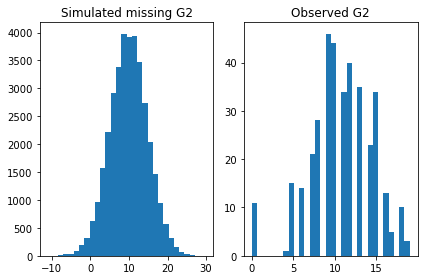

In [12]:
plt.subplot(121)
plt.hist(G2_sim.flatten(), bins=30)
plt.title(f'Simulated missing G2')

plt.subplot(122)
plt.hist(X.loc[:, "G2"], bins=30)
plt.title(f'Observed G2')

plt.tight_layout()
#plt.savefig('figures/MAR_0.1_G2.png')
plt.show()

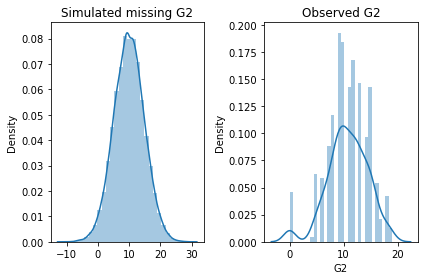

In [13]:
plt.subplot(121)
sns.distplot(G2_sim.flatten(), bins=30)
plt.title(f'Simulated missing G2')

plt.subplot(122)
sns.distplot(X.loc[:, "G2"], bins=30)
plt.title(f'Observed G2')

plt.tight_layout()
plt.savefig('figures/MAR_0.05_G2.png')
plt.show()